In [1]:
import seaborn as sn
import pandas as pd
import json, os

import tensorflow as tf
import numpy as np
import csv
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification #, BertModel, BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from collections import OrderedDict
import time
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
import random

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D

from sklearn.metrics import classification_report

seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


In [2]:
# user parameters
n_epochs = 10
batch_size = 6
lr = 5e-05
max_len = 512
model_variation = "microsoft/codebert-base-mlm"
tokenizer = AutoTokenizer.from_pretrained(model_variation, do_lower_case=True) #Tokenizer
#bert-base-uncased # roberta-base # distilbert-base-uncased # microsoft/codebert-base-mlm # microsoft/graphcodebert-base
# TFAutoModelForSequenceClassification # BertModel # 'albert-base-v2' # 'facebook/bart-base'

# Define New tokens for string and numerical i.e., strId$ and numId$
new_tokens = ["strId$", "numId$"]
for new_token in new_tokens:
    if new_token not in tokenizer.get_vocab().keys():
        tokenizer.add_tokens(new_token)

def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

def f2_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f2 = 5*((prec*rec)/(4*prec+rec+K.epsilon()))
    return f2

def dropEmpty(tokens0):
    tokens = []
    for i in range(0, len(tokens0)):
        temp = tokens0[i]
        if temp != []:
            tokens.append(temp)
    return tokens

def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string 
    count = 0
    for ele in s: 
        if count==0:
            str1 = str1 + ele
        else:
            str1 = str1 + ' ' + ele
        count = count + 1
        #str1 += ele  
    
    # return string  
    return str1

def prepareData(data):
        
    # lowercase
    lines = []
    labels = []
    headlines = []
    for i in range(0, len(data)):
        labels.append(int(data[i][1]))
        headlines.append(data[i][0])
        line = data[i][2:]
        lows = [w.lower() for w in line]
        lines.append(lows)
    
    texts = []
    for i in range(0, len(lines)):
        texts.append(listToString(lines[i]))
    
    return texts, labels, headlines 
    
def getLengths(data):
    lens = []
    for i in range(len(data)):
        lens.append(len(data[i])-2)
    lens = pd.DataFrame(lens)
    lensFreq = lens[0].value_counts()
    lensFreq=pd.DataFrame(lensFreq)
    return lens, lensFreq

def getLabels(data):
    values = []
    for i in range(len(data)):
        values.append(int(data[i][1]))
    serVal = pd.DataFrame(values)
    return serVal

In [3]:
# Read pythonvp directory and construct train and test csv files.
def extract_tokens_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        try:
            content = file.read()
            tokens = content.split()  # Split content into words
            return ','.join(tokens)
        except:
            return ""

def create_csv(directory, output_csv):
    with open(output_csv, 'w', newline='', encoding='utf-8') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['File', 'Tokens'])

        for root, _, files in os.walk(directory):
            for file in files:
                file_path = os.path.join(root, file)
                tokens = extract_tokens_from_file(file_path)
                csv_writer.writerow([file_path, tokens])

def add_label_to_csv(input_csv, label_value, output_csv):
    df = pd.read_csv(input_csv)
    df['Label'] = label_value
    df.to_csv(output_csv, index=False)

def concatenate_csvs(csv1, csv2, output_csv):
    df1 = pd.read_csv(csv1)
    df2 = pd.read_csv(csv2)
    merged_df = pd.concat([df1, df2], ignore_index=True)
    merged_df.to_csv(output_csv, index=False)

base_directory = 'pythonvp'
train_clean_csv = 'train_clean.csv'
train_vuln_csv = 'train_vuln.csv'
val_clean_csv = 'val_clean.csv'
val_vuln_csv = 'val_vuln.csv'
train_val_clean_csv = 'train_val_clean.csv'
train_val_vuln_csv = 'train_val_vuln.csv'
test_clean_csv = 'test_clean.csv'
test_vuln_csv = 'test_vuln.csv'
test_clean_labeled_csv = 'test_clean_labeled.csv'
test_vuln_labeled_csv = 'test_vuln_labeled.csv'
train_val_clean_labeled_csv = 'train_val_clean_labeled.csv'
train_val_vuln_labeled_csv = 'train_val_vuln_labeled.csv'
train_clean_labeled_csv = 'train_clean_labeled.csv'
train_vuln_labeled_csv = 'train_vuln_labeled.csv'
val_clean_labeled_csv = 'val_clean_labeled.csv'
val_vuln_labeled_csv = 'val_vuln_labeled.csv'
train_val_merged_csv = 'train_val_merged.csv'
train_merged_csv = 'train_merged.csv'
val_merged_csv = 'val_merged.csv'
test_merged_csv = 'test_merged.csv'

train_val_clean_dir = os.path.join(base_directory, 'train_val', 'clean')
train_val_vuln_dir = os.path.join(base_directory, 'train_val', 'vuln')
train_clean_dir = os.path.join(base_directory, 'train', 'clean')
train_vuln_dir = os.path.join(base_directory, 'train', 'vuln')
val_clean_dir = os.path.join(base_directory, 'val', 'clean')
val_vuln_dir = os.path.join(base_directory, 'val', 'vuln')
test_clean_dir = os.path.join(base_directory, 'test', 'clean')
test_vuln_dir = os.path.join(base_directory, 'test', 'vuln')

create_csv(train_val_clean_dir, train_val_clean_csv)
create_csv(train_val_vuln_dir, train_val_vuln_csv)
create_csv(train_clean_dir, train_clean_csv)
create_csv(train_vuln_dir, train_vuln_csv)
create_csv(val_clean_dir, val_clean_csv)
create_csv(val_vuln_dir, val_vuln_csv)
create_csv(test_clean_dir, test_clean_csv)
create_csv(test_vuln_dir, test_vuln_csv)

# Add label column with value 0 to train_val_clean_csv
add_label_to_csv(train_val_clean_csv, 0, train_val_clean_labeled_csv)

# Add label column with value 1 to train_val_vuln_csv
add_label_to_csv(train_val_vuln_csv, 1, train_val_vuln_labeled_csv)

# Add label column with value 0 to test_clean_csv
add_label_to_csv(test_clean_csv, 0, test_clean_labeled_csv)

# Add label column with value 1 to test_vuln_csv
add_label_to_csv(test_vuln_csv, 1, test_vuln_labeled_csv)

add_label_to_csv(train_clean_csv, 0, train_clean_labeled_csv)
add_label_to_csv(train_vuln_csv, 1, train_vuln_labeled_csv)
add_label_to_csv(val_clean_csv, 0, val_clean_labeled_csv)
add_label_to_csv(val_vuln_csv, 1, val_vuln_labeled_csv)


concatenate_csvs(train_val_clean_labeled_csv, train_val_vuln_labeled_csv, train_val_merged_csv)
concatenate_csvs(test_clean_labeled_csv, test_vuln_labeled_csv, test_merged_csv)
concatenate_csvs(train_clean_labeled_csv, train_vuln_labeled_csv, train_merged_csv)
concatenate_csvs(val_clean_labeled_csv, val_vuln_labeled_csv, val_merged_csv)


In [4]:
with open(train_val_merged_csv, newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = data[1:]

train_val_data = []
for i in range(0, len(data)):
    d = data[i]
    new_row = [d[0]]
    input_string = d[1]
    string_list = input_string.split(',')
    new_row.extend(string_list)
    new_row.append(d[2]) 
    train_val_data.append(new_row)

with open(train_merged_csv, newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = data[1:]

train_data = []
for i in range(0, len(data)):
    d = data[i]
    new_row = [d[0]]
    input_string = d[1]
    string_list = input_string.split(',')
    new_row.extend(string_list)
    new_row.append(d[2]) 
    train_data.append(new_row)

with open(val_merged_csv, newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = data[1:]

val_data = []
for i in range(0, len(data)):
    d = data[i]
    new_row = [d[0]]
    input_string = d[1]
    string_list = input_string.split(',')
    new_row.extend(string_list)
    new_row.append(d[2]) 
    val_data.append(new_row)
    

with open(test_merged_csv, newline='', encoding='utf-8') as f:
    reader = csv.reader(f)
    data = list(reader)
data = data[1:]

test_data = []
for i in range(0, len(data)):
    d = data[i]
    new_row = [d[0]]
    input_string = d[1]
    string_list = input_string.split(',')
    new_row.extend(string_list)
    new_row.append(d[2]) 
    test_data.append(new_row)
test_data


[['pythonvp\\test\\clean\\0002_add_field.py',
  'class',
  'Migration',
  'migrations',
  'Migration',
  'dependencies',
  'strId$',
  'strId$',
  'operations',
  'migrations',
  'migrations',
  'AddField',
  'model_name',
  'strId$',
  'name',
  'strId$',
  'field',
  'models',
  'TextField',
  '0'],
 ['pythonvp\\test\\clean\\0002_add_missing_model_change_migrations.py',
  'class',
  'Migration',
  'migrations',
  'Migration',
  'dependencies',
  'strId$',
  'strId$',
  'operations',
  'migrations',
  'AlterField',
  'model_name',
  'strId$',
  'name',
  'strId$',
  'field',
  'models',
  'CharField',
  'choices',
  'strId$',
  'strId$',
  'strId$',
  'strId$',
  'strId$',
  'strId$',
  'strId$',
  'strId$',
  'strId$',
  'strId$',
  'help_text',
  'strId$',
  'max_length',
  'numId$',
  'verbose_name',
  'strId$',
  'migrations',
  'AlterField',
  'model_name',
  'strId$',
  'name',
  'strId$',
  'field',
  'models',
  'CharField',
  'blank',
  'True',
  'db_index',
  'True',
  'help

In [5]:
train_val_len = len(train_val_data)
train_len = len(train_data)
val_len = len(val_data)
test_len = len(test_data)


train_val_labels = []
for inner_list in train_val_data:
    last_element = inner_list.pop() 
    train_val_labels.append(last_element)

train_labels = []
for inner_list in train_data:
    last_element = inner_list.pop() 
    train_labels.append(last_element)

val_labels = []
for inner_list in val_data:
    last_element = inner_list.pop() 
    val_labels.append(last_element)
    
test_labels = []
for inner_list in test_data:
    last_element = inner_list.pop() 
    test_labels.append(last_element)

In [6]:
train_val_data2 = []
for i in range(0, len(train_val_data)):
    line = train_val_data[i][1:]
    lows = [w.lower() for w in line]
    train_val_data2.append(lows)
    
train_data2 = []
for i in range(0, len(train_data)):
    line = train_data[i][1:]
    lows = [w.lower() for w in line]
    train_data2.append(lows)

val_data2 = []
for i in range(0, len(val_data)):
    line = val_data[i][1:]
    lows = [w.lower() for w in line]
    val_data2.append(lows)
    
test_data2 = []
for i in range(0, len(test_data)):
    line = test_data[i][1:]
    lows = [w.lower() for w in line]
    test_data2.append(lows)


In [7]:
train_val_data_input = [' '.join(sublist) for sublist in train_val_data2]
train_data_input = [' '.join(sublist) for sublist in train_data2]
val_data_input = [' '.join(sublist) for sublist in val_data2]
test_data_input = [' '.join(sublist) for sublist in test_data2]

In [8]:
# shuffle data

In [9]:
train_val_isVulnerable = pd.Series(train_val_labels)
train_isVulnerable = pd.Series(train_labels)
val_isVulnerable = pd.Series(val_labels)
test_isVulnerable = pd.Series(test_labels)

In [10]:
n_categories = 2
model = TFAutoModelForSequenceClassification.from_pretrained(model_variation, num_labels=n_categories)

config = model.get_config()
print(config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'typical_p': 1.0, 'repetition_penalty': 1.0, 'length_penalty': 1.0, 'no_repeat_ngram_size': 0, 'encoder_no_repeat_ngram_size': 0, 'bad_words_ids': None, 'num_return_sequences': 1, 'chunk_size_feed_forward': 0, 'output_scores': False, 'return_dict_in_generate': False, 'forced_bos_token_id': None, 'forced_eos_token_id': None, 'remove_invalid_values': False, 'exponential_decay_length_penalty': None, 'suppress_tokens': None, 'begin_suppress_

In [11]:
X_train = tokenizer(
    text=train_data_input,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=val_data_input,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_train

{'input_ids': <tf.Tensor: shape=(3022, 512), dtype=int32, numpy=
array([[    0,  4684,  8702, ...,  1528,  7031,     2],
       [    0,  4684,  8702, ...,     1,     1,     1],
       [    0, 33869,  4682, ...,     1,     1,     1],
       ...,
       [    0,   366,  2718, ..., 15009,   808,     2],
       [    0, 30529, 11515, ...,  1629,   939,     2],
       [    0,  4684,  6880, ...,   808,  1629,     2]])>, 'attention_mask': <tf.Tensor: shape=(3022, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])>}

In [12]:
'''input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
#K.print_tensor(input_ids)

embeddings = model(input_ids, attention_mask = input_mask)[0] # 0 = last hidden state, 1 = poller_output

out = Dense(128, activation='relu')(embeddings)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32, activation='relu')(out)
y = Dense(2, activation='softmax')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)'''
#model.layers[2].trainable = True

optimizer = Adam(
    learning_rate=lr, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

loss = CategoricalCrossentropy(from_logits=True)
#metric = CategoricalAccuracy('balanced_accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[f2_metric]
)

history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(train_isVulnerable),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        to_categorical(val_isVulnerable)),
    epochs=1,
    batch_size=batch_size
)

504/504 [==============================] - 307s 577ms/step - loss: 0.3939 - f2_metric: 0.7258 - val_loss: 0.2745 - val_f2_metric: 0.8112


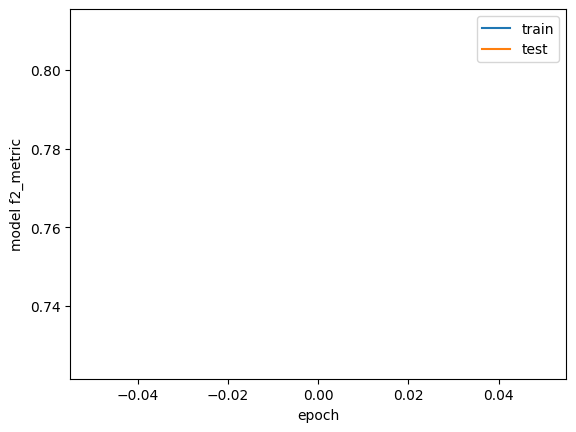

In [13]:
plt.plot(history.history['f2_metric'])
plt.plot(history.history['val_f2_metric'])
plt.ylabel('model f2_metric')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.savefig('train_history.png')
plt.show()

In [14]:
val_isVulnerable = val_isVulnerable.astype(int)
predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}).logits
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(val_isVulnerable, y_predicted))

tn, fp, fn, tp = confusion_matrix(val_isVulnerable, y_predicted).ravel()
acc=(tp+tn)/(tp+tn+fp+fn)
prec=tp/(tp+fp)
rec=tp/(tp+fn)
f1=2*prec*rec / (prec+rec)
f2=5*prec*rec / (4*prec+rec)
print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1-score: ", f1)
print("F2-score: ", f2)

17/17 [==============================] - 14s 719ms/step
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       407
           1       0.82      0.66      0.73       127

    accuracy                           0.89       534
   macro avg       0.86      0.81      0.83       534
weighted avg       0.88      0.89      0.88       534

Accuracy:  0.8857677902621723
Precision:  0.8235294117647058
Recall:  0.6614173228346457
F1-score:  0.7336244541484717
F2-score:  0.6885245901639344


In [15]:
tn, fp, fn, tp = confusion_matrix(val_isVulnerable, y_predicted).ravel()
acc=(tp+tn)/(tp+tn+fp+fn)
prec=tp/(tp+fp)
rec=tp/(tp+fn)
f1=2*prec*rec / (prec+rec)
f2=5*prec*rec / (4*prec+rec)
print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1-score: ", f1)
print("F2-score: ", f2)

Accuracy:  0.8857677902621723
Precision:  0.8235294117647058
Recall:  0.6614173228346457
F1-score:  0.7336244541484717
F2-score:  0.6885245901639344


In [16]:
#f2 = 5*78*85 / (4*78+85)
#print(f2)

In [17]:
X_test['input_ids']

<tf.Tensor: shape=(534, 512), dtype=int32, numpy=
array([[    0,  4684,  8702, ...,     1,     1,     1],
       [    0,  4684,  8702, ...,     1,     1,     1],
       [    0,  4684,  8702, ...,     1,     1,     1],
       ...,
       [    0,  3340, 46918, ..., 30766,  5780,     2],
       [    0, 17265,  7031, ...,     1,     1,     1],
       [    0,  4684,  6880, ...,   808,  1629,     2]])>

In [18]:
val_isVulnerable

0      0
1      0
2      0
3      0
4      0
      ..
529    1
530    1
531    1
532    1
533    1
Length: 534, dtype: int32

In [19]:
#y_predicted

In [20]:
avg_acc = []
avg_prec = []
avg_rec = []
avg_f1 = []
avg_f2 = []
num_loops = 5
for i in range(0, num_loops):
    print(i)
    del model
    model = TFAutoModelForSequenceClassification.from_pretrained(model_variation, num_labels=n_categories)
    model.resize_token_embeddings(len(tokenizer))

    X_train = tokenizer(
        text=train_val_data_input,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

    X_test = tokenizer(
        text=test_data_input,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )


    n_epochs = 6 # number of epochs based on the optimal number as identified on the validation data

    optimizer = Adam(
        learning_rate=lr, # HF recommendation
        epsilon=1e-08,
        decay=0.01,
        clipnorm=1.0
    )

    loss = CategoricalCrossentropy(from_logits=True)
    #metric = CategoricalAccuracy('balanced_accuracy')

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[f2_metric]
    )

    history = model.fit(
        x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
        y = to_categorical(train_val_isVulnerable),
        validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                            to_categorical(test_isVulnerable.astype(int))),
        epochs=n_epochs,
        batch_size=batch_size
    )


    test_isVulnerable = test_isVulnerable.astype(int)
    predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}).logits
    y_predicted = np.argmax(predicted, axis=1)
    print(classification_report(test_isVulnerable, y_predicted))

    tn, fp, fn, tp = confusion_matrix(test_isVulnerable, y_predicted).ravel()
    acc=(tp+tn)/(tp+tn+fp+fn)
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    f1=2*prec*rec / (prec+rec)
    f2=5*prec*rec / (4*prec+rec)
    print("Accuracy: ", acc)
    print("Precision: ", prec)
    print("Recall: ", rec)
    print("F1-score: ", f1)
    print("F2-score: ", f2)
    
    avg_acc.append(acc)
    avg_prec.append(prec)
    avg_rec.append(rec)
    avg_f1.append(f1)
    avg_f2.append(f2)
    
print("\n")
print("AVG Accuracy: ", sum(avg_acc)/5)
print("AVG Precision: ", sum(avg_prec)/5)
print("AVG Recall: ", sum(avg_rec)/5)
print("AVG F1-score: ", sum(avg_f1)/5)
print("AVG F2-score: ", sum(avg_f2)/5)

0


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
593/593 [==============================] - 359s 582ms/step - loss: 0.5580 - f2_metric: 0.5344 - val_loss: 0.5494 - val_f2_metric: 0.7587
Epoch 2/6
593/593 [==============================] - 343s 578ms/step - loss: 0.4840 - f2_metric: 0.5898 - val_loss: 0.3588 - val_f2_metric: 0.7075
Epoch 3/6
593/593 [==============================] - 343s 578ms/step - loss: 0.3328 - f2_metric: 0.7780 - val_loss: 0.3183 - val_f2_metric: 0.7883
Epoch 4/6
593/593 [==============================] - 343s 578ms/step - loss: 0.2803 - f2_metric: 0.8211 - val_loss: 0.2989 - val_f2_metric: 0.8287
Epoch 5/6
593/593 [==============================] - 343s 578ms/step - loss: 0.2467 - f2_metric: 0.8614 - val_loss: 0.3123 - val_f2_metric: 0.8473
Epoch 6/6
20/20 [==============================] - 16s 717ms/step
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       478
           1       0.69      0.79      0.74       150

    accuracy                       

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
593/593 [==============================] - 360s 582ms/step - loss: 0.3583 - f2_metric: 0.7402 - val_loss: 0.2422 - val_f2_metric: 0.8358
Epoch 2/6
593/593 [==============================] - 343s 579ms/step - loss: 0.1869 - f2_metric: 0.8741 - val_loss: 0.2679 - val_f2_metric: 0.8747
Epoch 3/6
593/593 [==============================] - 343s 579ms/step - loss: 0.1227 - f2_metric: 0.9264 - val_loss: 0.2643 - val_f2_metric: 0.8970
Epoch 4/6
593/593 [==============================] - 344s 580ms/step - loss: 0.0854 - f2_metric: 0.9560 - val_loss: 0.2949 - val_f2_metric: 0.9056
Epoch 5/6
593/593 [==============================] - 344s 580ms/step - loss: 0.0650 - f2_metric: 0.9680 - val_loss: 0.2896 - val_f2_metric: 0.9083
Epoch 6/6
20/20 [==============================] - 16s 720ms/step
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       478
           1       0.88      0.79      0.83       150

    accuracy                       

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
593/593 [==============================] - 366s 593ms/step - loss: 0.3757 - f2_metric: 0.7612 - val_loss: 0.2452 - val_f2_metric: 0.8436
Epoch 2/6
593/593 [==============================] - 343s 579ms/step - loss: 0.1961 - f2_metric: 0.8839 - val_loss: 0.2373 - val_f2_metric: 0.8764
Epoch 3/6
593/593 [==============================] - 343s 579ms/step - loss: 0.1237 - f2_metric: 0.9340 - val_loss: 0.2581 - val_f2_metric: 0.8981
Epoch 4/6
593/593 [==============================] - 344s 581ms/step - loss: 0.0859 - f2_metric: 0.9596 - val_loss: 0.2770 - val_f2_metric: 0.9064
Epoch 5/6
593/593 [==============================] - 345s 581ms/step - loss: 0.0650 - f2_metric: 0.9698 - val_loss: 0.2961 - val_f2_metric: 0.9091
Epoch 6/6
20/20 [==============================] - 16s 721ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       478
           1       0.84      0.83      0.84       150

    accuracy                       

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
593/593 [==============================] - 361s 585ms/step - loss: 0.4431 - f2_metric: 0.7152 - val_loss: 0.3568 - val_f2_metric: 0.8200
Epoch 2/6
593/593 [==============================] - 344s 581ms/step - loss: 0.2976 - f2_metric: 0.8282 - val_loss: 0.3052 - val_f2_metric: 0.8410
Epoch 3/6
593/593 [==============================] - 344s 581ms/step - loss: 0.2441 - f2_metric: 0.8690 - val_loss: 0.2983 - val_f2_metric: 0.8532
Epoch 4/6
593/593 [==============================] - 344s 581ms/step - loss: 0.2129 - f2_metric: 0.9019 - val_loss: 0.3118 - val_f2_metric: 0.8783
Epoch 5/6
593/593 [==============================] - 344s 581ms/step - loss: 0.1859 - f2_metric: 0.9152 - val_loss: 0.3011 - val_f2_metric: 0.8831
Epoch 6/6
20/20 [==============================] - 16s 721ms/step
              precision    recall  f1-score   support

           0       0.94      0.93      0.93       478
           1       0.78      0.81      0.79       150

    accuracy                       

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
593/593 [==============================] - 361s 585ms/step - loss: 0.3752 - f2_metric: 0.7173 - val_loss: 0.2569 - val_f2_metric: 0.8186
Epoch 2/6
593/593 [==============================] - 345s 581ms/step - loss: 0.2021 - f2_metric: 0.8702 - val_loss: 0.2611 - val_f2_metric: 0.8553
Epoch 3/6
593/593 [==============================] - 345s 581ms/step - loss: 0.1346 - f2_metric: 0.9210 - val_loss: 0.2801 - val_f2_metric: 0.8906
Epoch 4/6
593/593 [==============================] - 345s 581ms/step - loss: 0.1020 - f2_metric: 0.9491 - val_loss: 0.2959 - val_f2_metric: 0.8942
Epoch 5/6
593/593 [==============================] - 345s 582ms/step - loss: 0.0760 - f2_metric: 0.9591 - val_loss: 0.3290 - val_f2_metric: 0.8987
Epoch 6/6
20/20 [==============================] - 16s 721ms/step
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       478
           1       0.83      0.81      0.82       150

    accuracy                       

In [21]:
del model

In [22]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_variation, num_labels=n_categories)
# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

X_train = tokenizer(
    text=train_val_data_input,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=test_data_input,
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_train

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'input_ids': <tf.Tensor: shape=(3556, 512), dtype=int32, numpy=
array([[    0,  4684,  8702, ...,  1528,  7031,     2],
       [    0,  4684,  8702, ...,     1,     1,     1],
       [    0, 33869,  4682, ...,     1,     1,     1],
       ...,
       [    0, 30529, 11515, ...,  1629,   939,     2],
       [    0,  4684,  6880, ...,   808,  1629,     2],
       [    0,  4684,  6880, ...,   808,  1629,     2]])>, 'attention_mask': <tf.Tensor: shape=(3556, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])>}

In [23]:
n_epochs = 4 # number of epochs based on the optimal number as identified on the validation data

optimizer = Adam(
    learning_rate=lr, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

loss = CategoricalCrossentropy(from_logits=True)
#metric = CategoricalAccuracy('balanced_accuracy')

model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[f2_metric]
)

history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(train_val_isVulnerable),
    validation_data = ({'input_ids':X_test['input_ids'], 'attention_mask':X_test['attention_mask']},
                        to_categorical(test_isVulnerable.astype(int))),
    epochs=n_epochs,
    batch_size=batch_size
)

Epoch 1/4
593/593 [==============================] - 361s 584ms/step - loss: 0.3691 - f2_metric: 0.6720 - val_loss: 0.2484 - val_f2_metric: 0.8183
Epoch 2/4
593/593 [==============================] - 344s 581ms/step - loss: 0.1844 - f2_metric: 0.8752 - val_loss: 0.2737 - val_f2_metric: 0.8563
Epoch 3/4
593/593 [==============================] - 345s 581ms/step - loss: 0.1113 - f2_metric: 0.9337 - val_loss: 0.2684 - val_f2_metric: 0.8906
Epoch 4/4
593/593 [==============================] - 345s 581ms/step - loss: 0.0757 - f2_metric: 0.9589 - val_loss: 0.2933 - val_f2_metric: 0.8971


In [24]:
test_isVulnerable = test_isVulnerable.astype(int)
predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}).logits
y_predicted = np.argmax(predicted, axis=1)
print(classification_report(test_isVulnerable, y_predicted))

tn, fp, fn, tp = confusion_matrix(test_isVulnerable, y_predicted).ravel()
acc=(tp+tn)/(tp+tn+fp+fn)
prec=tp/(tp+fp)
rec=tp/(tp+fn)
f1=2*prec*rec / (prec+rec)
f2=5*prec*rec / (4*prec+rec)
print("Accuracy: ", acc)
print("Precision: ", prec)
print("Recall: ", rec)
print("F1-score: ", f1)
print("F2-score: ", f2)

20/20 [==============================] - 16s 720ms/step
              precision    recall  f1-score   support

           0       0.93      0.96      0.95       478
           1       0.86      0.79      0.82       150

    accuracy                           0.92       628
   macro avg       0.90      0.87      0.88       628
weighted avg       0.92      0.92      0.92       628

Accuracy:  0.9187898089171974
Precision:  0.8613138686131386
Recall:  0.7866666666666666
F1-score:  0.8222996515679442
F2-score:  0.8005427408412482


In [25]:
X_test['input_ids']

<tf.Tensor: shape=(628, 512), dtype=int32, numpy=
array([[   0, 4684, 8702, ...,    1,    1,    1],
       [   0, 4684, 8702, ...,    1,    1,    1],
       [   0, 4684, 8702, ...,    1,    1,    1],
       ...,
       [   0, 9232, 2718, ...,    1,    1,    1],
       [   0, 4684, 3816, ...,    1,    1,    1],
       [   0, 6031,  808, ...,    1,    1,    1]])>

In [26]:
test_isVulnerable

0      0
1      0
2      0
3      0
4      0
      ..
623    1
624    1
625    1
626    1
627    1
Length: 628, dtype: int32

In [27]:
y_predicted

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
#del model